# Experiment 6
In this experiment, the adversarial learning technique is dropped altogether, a single Variational Graph-based auto-encoder is used, using the torch geometry implementation of the VGAE

VGAE proved to be inferior (to be tested) so back to experimenting with a model written from scratch

In [1]:
!ls ../../Projects/data/

 MNIST			       SWaT_Dataset_Normal_v1.xlsx
 SWaT_Dataset_Attack_v0.csv    WADI_14days_new.csv
 SWaT_Dataset_Attack_v0.xlsx  'WADI.A1_9 Oct 2017'
 SWaT_Dataset_Normal_v0.csv   'WADI.A2_19 Nov 2019'
 SWaT_Dataset_Normal_v0.xlsx   WADI_attackdataLABLE.csv
 SWaT_Dataset_Normal_v1.csv


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.optim import Adam
from torch_geometric.nn import GAE, VGAE, GCNConv
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from layers import *

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

### Dataset:

In [2]:
df = pd.read_csv('../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')
mm = StandardScaler()
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataloader:

In [11]:
window_size = 100

train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Model:

In [4]:
class GEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(GEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.window_size = window_size
        self.conv1 = GCNLayer(window_size, 20)
        self.conv2 = GCNLayer(20, 5)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_Directed_A(num_nodes, window_size, alpha, k, device)
        self.device = device

    def forward(self, X):
        X = torch.transpose(X, 1, 2)
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return h
        
        

class GCN_autoencoder(nn.Module):
    def __init__(self, encoder, num_nodes, window_size):
        super(GCN_autoencoder, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(255, 515),
            nn.ReLU(),
            nn.Linear(515, num_nodes * window_size)
        )
        
    def forward(self, X):
        x = self.encoder(X)
        x = torch.flatten(x,1)
        x = self.decoder(x)
        return x.view(-1, self.window_size, self.num_nodes)

    def get_adj(self):
        return self.encoder.A(self.encoder.idx)

In [8]:
num_nodes = 51 # number of nodes
ngnn = 1 # number of graph structure learning layers
gsllayer = 'directed' # type of graph structure learning layer ('relu', 'directed', 'unidirected', 'undirected')
hidden_nodes = 50 # feature size in GCN layers
alpha = 0.15 # hyperparameter for weights of edges
k = None  # max number of edges for each node
epochs = 15
out_channels = 2 # number of process states

In [12]:
Encoder = GEncoder(num_nodes, window_size, alpha, k, device)
AE1 = GCN_autoencoder(Encoder, num_nodes, window_size)

In [13]:
AE1.to(device)

GCN_autoencoder(
  (encoder): GEncoder(
    (conv1): GCNLayer(
      (dense): Linear(in_features=100, out_features=20, bias=True)
    )
    (conv2): GCNLayer(
      (dense): Linear(in_features=20, out_features=5, bias=True)
    )
    (A): Graph_Directed_A(
      (e1): Embedding(51, 100)
      (e2): Embedding(51, 100)
      (l1): Linear(in_features=100, out_features=100, bias=True)
      (l2): Linear(in_features=100, out_features=100, bias=True)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=255, out_features=515, bias=True)
    (1): ReLU()
    (2): Linear(in_features=515, out_features=5100, bias=True)
  )
)

In [14]:
optimizer1 = torch.optim.Adam(AE1.parameters())

In [10]:
# from torch.utils.tensorboard import SummaryWriter

In [35]:
AE1_val_history = []
for i in range(2):
    running_loss_AE1 = []
    val_loss_AE1 = []
    for index_b, features in enumerate(train_loader):
        
        w1 = AE1(features)
        lossAE1 = torch.mean((features - w1) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():

            w1 = AE1(features)
            lossAE1 = torch.mean((features - w1) ** 2)
            val_loss_AE1.append(lossAE1)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    # writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    # writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 0.0090
Train loss: AE1 0.0091
Epoch: 1 ---> Val loss: AE1 0.0089
Train loss: AE1 0.0088


# Testing

In [16]:
df2 = pd.read_csv('../../Projects/data/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = df.columns
test_normalized = pd.DataFrame(mm.transform(df2))

In [17]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [43]:
def testing(loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in loader:
            w1=AE1(batch)
            results.append(torch.mean((batch-w1)**2, axis=1))
    return results

In [42]:
def get_threshold(val_loader):
    recon_errors = testing(val_loader)
    complete_vals = np.concatenate([torch.stack(recon_errors[:-1]).view(-1, num_nodes).detach().cpu().numpy(),
                                    recon_errors[-1].view(-1, num_nodes).detach().cpu().numpy()])
    return np.max(complete_vals, axis=0)

In [44]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

AttributeError: 'list' object has no attribute 'values'

In [21]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [45]:
thresholds = get_threshold(validation_loader) * 1.5
results=testing(test_loader, alpha=0.3, beta=0.7)
y_pred=np.concatenate([torch.stack(results[:-1]).view(-1, num_nodes).detach().cpu().numpy(), 
                       results[-1].view(-1, num_nodes).detach().cpu().numpy()])

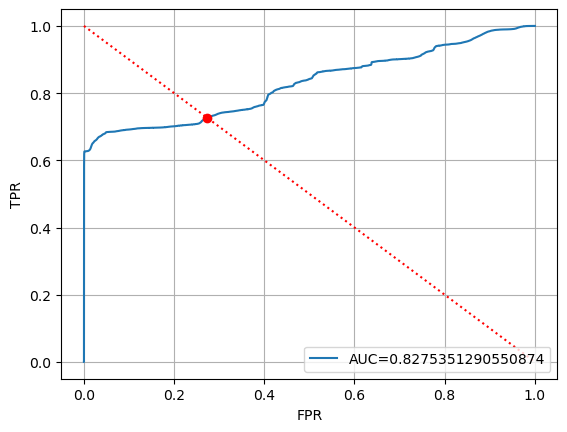

array([0.9440274], dtype=float32)

In [38]:
threshold = ROC(y_test,y_pred)
threshold

In [93]:
thresholds = thresholds * 0.9

In [94]:
res = y_pred > thresholds

In [95]:
boo = np.any(res, axis = 1)
verdicts = [1 if elem else 0 for elem in boo]
conf_matrix = confusion_matrix(y_test, verdicts)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
F1 = f1_score(y_test, verdicts)
precision = precision_score(y_test, verdicts)
recall = recall_score(y_test, verdicts)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", F1)
print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')

Precision: 0.9498677891101398
Recall: 0.6069445881176511
F1 Score: 0.7406378860557099
TP: 35204
TN: 389959
FP: 1858
FN: 22798


In [64]:
F1

0.2616124305143452

best: 1.3 F1: 0.7664679504088631


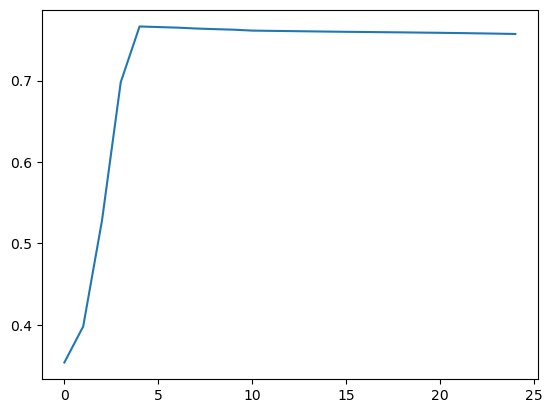

In [39]:
ff = 0
f_history = []
initial_y = 0.8
best = -1
for inc in np.linspace(0, 3, 25):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

# Loading and saving the model

In [15]:
AE1.load_state_dict(torch.load('Continue_in_copy2.pth'))

<All keys matched successfully>

In [40]:
torch.save(AE1.state_dict(), 'Continue_in_copy2.pth')

# Analyzing the results

In [41]:
X_ind = np.array([i for i in range(100)])
X_ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [46]:
features = torch.transpose(features, 1, 2)

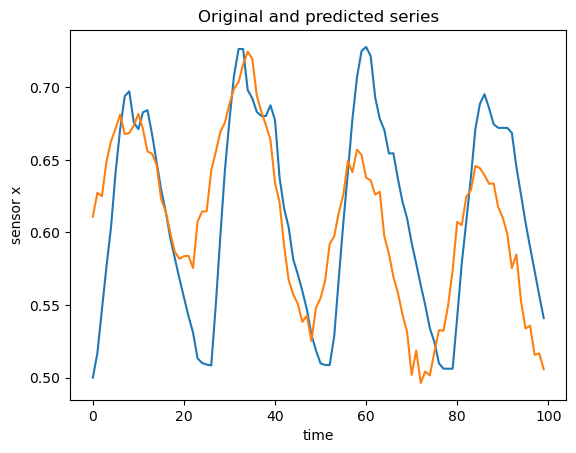

In [47]:
AE1.eval()
with torch.no_grad():
    output = AE1(features)
output = torch.transpose(output, 1, 2)
features = torch.transpose(features, 1, 2)
plt.plot(X_ind, features[0, 0, :].cpu(), label='Original signal')
plt.plot(X_ind, output[0, 0, :].cpu(), label='Predicted signal')
plt.xlabel('time')
plt.ylabel('sensor x')
plt.title('Original and predicted series')
plt.show()
output = torch.transpose(output, 1, 2)
features = torch.transpose(features, 1, 2)